In [196]:
import sys
import os
import numpy as np

# Add the 'oracle' directory to the Python path
sys.path.append(os.path.join(os.getcwd(), 'oracle'))
import oracle as oracle 

In [197]:
res = oracle.q2_train_test_emnist(23607, "./EMNIST/emnist-balanced-train.csv", "./EMNIST/emnist-balanced-test.csv")
print(res)

(array([[ 5,  0,  0, ...,  0,  0,  0],
       [27,  0,  0, ...,  0,  0,  0],
       [27,  0,  0, ...,  0,  0,  0],
       ...,
       [27,  0,  0, ...,  0,  0,  0],
       [27,  0,  0, ...,  0,  0,  0],
       [ 5,  0,  0, ...,  0,  0,  0]], shape=(4800, 785)), array([[27,  0,  0, ...,  0,  0,  0],
       [ 5,  0,  0, ...,  0,  0,  0],
       [ 5,  0,  0, ...,  0,  0,  0],
       ...,
       [ 5,  0,  0, ...,  0,  0,  0],
       [ 5,  0,  0, ...,  0,  0,  0],
       [27,  0,  0, ...,  0,  0,  0]], shape=(800, 785)))


In [198]:
train = res[0]
test = res[1]

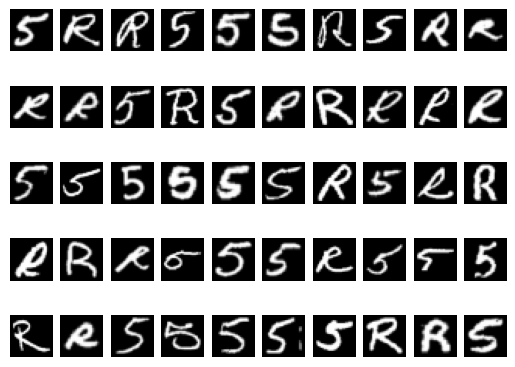

In [199]:
show = train[:50]
for i in range(50):
    first = show[i][1:]
    first = np.array(first)
    first = first.reshape(28, 28)
    first = first.T
    import matplotlib.pyplot as plt
    # show in a grid
    plt.subplot(5, 10, i+1)
    plt.imshow(first, cmap='gray')
    plt.axis('off')
plt.show()




In [200]:
# count the number of labels for each class
class_count = {}
for i in range(len(train)):
    label = train[i][0]
    if label not in class_count:
        class_count[label] = 1
    else:
        class_count[label] += 1
print(class_count)

{np.int64(5): 2400, np.int64(27): 2400}


In [201]:
class_1 = 5
class_2 = 27

So 2400 labels each for 5 and 27, so p1 = p2 = 1/2

In [202]:
# since probability is same:
def h(x, m1, m2):
    return np.dot((m1 - m2).T , (x - (m1 + m2)/2))

In [203]:
m1 = np.zeros(784)
m2 = np.zeros(784)

for i in range(len(train)):
    if train[i][0] == class_1:
        m1 += np.array(train[i][1:])
    else:
        m2 += np.array(train[i][1:])
m1 /= class_count[class_1]
m2 /= class_count[class_2]


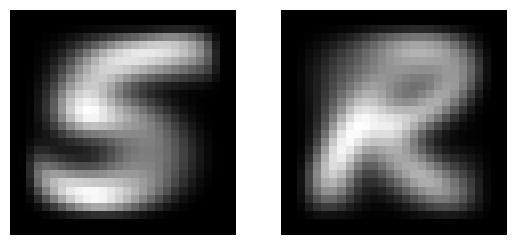

In [204]:
m1_plot = m1.reshape(28, 28)
m1_plot = m1_plot.T

m2_plot = m2.reshape(28, 28)
m2_plot = m2_plot.T

# show in a grid
plt.subplot(1, 2, 1)
plt.imshow(m1_plot, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(m2_plot, cmap='gray')
plt.axis('off')
plt.show()


In [205]:
true_count = 0
false_count = 0
no_class_count = 0
epsilon = 0.0 # for now, change this later

for i in range(len(test)):
    x = np.array(test[i][1:])
    label = test[i][0]
    res = np.dot((m1 - m2).T , (x - (m1 + m2)/2))
    no_class_margin = epsilon * np.linalg.norm(m1 - m2)* np.linalg.norm(x - (m1 + m2)/2)
    if res > no_class_margin and label == class_1:
        true_count += 1
    elif res < -no_class_margin and label == class_2:    
        true_count += 1
    elif res < no_class_margin and res > -no_class_margin:
        no_class_count += 1
    else:
        false_count += 1
print(true_count/len(test))
print(false_count/len(test))
print(no_class_count/len(test))


0.95125
0.04875
0.0


In [206]:
import numpy as np

# Assuming train is already defined
train_class5 = []
train_class27 = []
for i in range(len(train)):
    if train[i][0] == class_1:
        train_class5.append(train[i][1:])
    else:
        train_class27.append(train[i][1:])
        
# Convert to numpy arrays with float64 precision
train_class5 = np.array(train_class5, dtype=np.float64)
train_class27 = np.array(train_class27, dtype=np.float64)

# Compute covariance matrices (features are along columns)
cov5 = np.cov(train_class5.T)
cov27 = np.cov(train_class27.T)

# Regularization: add a small constant to the diagonal elements
epsilon = 1e-6  # You can adjust this value if needed
cov5_reg = cov5 + epsilon * np.eye(cov5.shape[0])
cov27_reg = cov27 + epsilon * np.eye(cov27.shape[0])

def log_N(x, m, cov, d):
    """
    Compute the log of the multivariate normal density for a given x.
    """
    from math import log, pi
    # Using slogdet for better numerical stability
    sign, logdet = np.linalg.slogdet(cov)
    if sign <= 0:
        raise ValueError("Covariance matrix is not positive definite.")
    const = -d / 2 * log(2 * pi) - 0.5 * logdet
    # Here, using np.linalg.inv is acceptable because we've regularized the matrix.
    exp_term = -0.5 * np.dot(np.dot((x - m).T, np.linalg.inv(cov)), (x - m))
    return const + exp_term

def log_eta(p, log_N_):
    """
    Combine the log prior p and the log likelihood to compute a log-posterior (up to a constant).
    """
    from math import log
    return log(p) + log_N_


d = 784
data = train_class27[4]
eta5 = log_eta(class_count[class_1] / len(train), log_N(data, m1, cov5_reg, d))
eta27 = log_eta(class_count[class_2] / len(train), log_N(data, m2, cov27_reg, d))

print("Log eta for class 5:", eta5)
print("Log eta for class 27:", eta27)


Log eta for class 5: -3010.302828075355
Log eta for class 27: -1870.7966538926123


In [207]:
print(np.linalg.det(cov5))
print(np.linalg.det(cov27))

0.0
0.0


In [208]:
import numpy as np

# Assuming eta5 and eta27 are your computed log values
# For numerical stability, subtract the maximum log value
max_log = max(eta5, eta27)
exp_eta5 = np.exp(eta5 - max_log)
exp_eta27 = np.exp(eta27 - max_log)

# Normalize the probabilities so they sum to 1
posterior_5 = exp_eta5 / (exp_eta5 + exp_eta27)
posterior_27 = exp_eta27 / (exp_eta5 + exp_eta27)

print("Posterior probability for class 5:", posterior_5)
print("Posterior probability for class 27:", posterior_27)


Posterior probability for class 5: 0.0
Posterior probability for class 27: 1.0


In [209]:
d = 784
test_class5 = []
test_class27 = []
for i in range(len(test)):
    if test[i][0] == class_1:
        test_class5.append(test[i][1:])
    else:
        test_class27.append(test[i][1:])



In [210]:
false_count = 0
no_class_count = 0
epsilon = 0.1

In [211]:
# overall error rate incorporating no class, epsilon = 0.1


for i,data in enumerate(test):
    eta5 = log_eta(class_count[class_1] / len(train), log_N(data[1:], m1, cov5_reg, d))
    eta27 = log_eta(class_count[class_2] / len(train), log_N(data[1:], m2, cov27_reg, d))

    max_log = max(eta5, eta27)
    exp_eta5 = np.exp(eta5 - max_log)
    exp_eta27 = np.exp(eta27 - max_log)

    # Normalize the probabilities so they sum to 1
    posterior_5 = exp_eta5 / (exp_eta5 + exp_eta27)
    posterior_27 = exp_eta27 / (exp_eta5 + exp_eta27)

    # print(posterior_5, posterior_27)

    if abs(posterior_5 - posterior_27) < 2*epsilon:
        no_class_count += 1
        continue
    if posterior_5 < posterior_27 and data[0] == class_1:
        # print(i)
        false_count += 1
        # print(posterior_5, posterior_27)
    elif posterior_5 > posterior_27 and data[0] == class_2:
        false_count += 1
        # print(posterior_5, posterior_27)

print()
print(false_count/len(test))
print(no_class_count/len(test))

KeyboardInterrupt: 

In [ ]:
threshold = np.log((0.5 + epsilon) / (0.5 - epsilon))
print(threshold)

0.4054651081081642


In [212]:
def result(train, test, epsilon):
    # Assuming train is already defined
    d = 784
    train_class5 = []
    train_class27 = []
    class_count = {class_1: 0, class_2: 0}
    for i in range(len(train)):
        if train[i][0] == class_1:
            train_class5.append(train[i][1:])
            class_count[class_1] += 1
        else:
            train_class27.append(train[i][1:])
            class_count[class_2] += 1
    
    # Convert to numpy arrays with float64 precision
    train_class5 = np.array(train_class5, dtype=np.float64)
    train_class27 = np.array(train_class27, dtype=np.float64)

    m1 = np.mean(train_class5, axis=0)
    m2 = np.mean(train_class27, axis=0)

    cov5 = np.cov(train_class5.T)
    cov27 = np.cov(train_class27.T)

    # Regularization: add a small constant to the diagonal elements
    eps = 1e-6  # You can adjust this value if needed
    cov5_reg = cov5 + eps * np.eye(cov5.shape[0])
    cov27_reg = cov27 + eps * np.eye(cov27.shape[0])

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    no_class_count = 0  
    for i,data in enumerate(test):
        eta5 = log_eta(class_count[class_1] / len(train), log_N(data[1:], m1, cov5_reg, d))
        eta27 = log_eta(class_count[class_2] / len(train), log_N(data[1:], m2, cov27_reg, d))

        max_log = max(eta5, eta27)
        exp_eta5 = np.exp(eta5 - max_log)
        exp_eta27 = np.exp(eta27 - max_log)

        # Normalize the probabilities so they sum to 1
        posterior_5 = exp_eta5 / (exp_eta5 + exp_eta27)
        posterior_27 = exp_eta27 / (exp_eta5 + exp_eta27)


        if abs(posterior_5 - posterior_27) < 2*epsilon:
            no_class_count += 1
            continue
        if posterior_5 < posterior_27 and data[0] == class_1:
            FN += 1
        elif posterior_5 > posterior_27 and data[0] == class_2:
            FP += 1
        elif posterior_5 > posterior_27 and data[0] == class_1:
            TP += 1
        elif posterior_5 < posterior_27 and data[0] == class_2:
            TN += 1

    # print()
    # print(false_count/len(test))
    # print(no_class_count/len(test))
    return {'no_class_count': no_class_count, 'class5_count': class_count[class_1], 'class27_count': class_count[class_2], 'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}

In [ ]:
ratios = [1, 40/60, 20/80, 10/90, 1/99]
# 60-40 ratio of class 5 and class 27
for ratio in ratios:
    print("ratio",ratio)
    res = oracle.q2_train_test_emnist(23607, "./EMNIST/emnist-balanced-train.csv", "./EMNIST/emnist-balanced-test.csv")
    train = res[0]
    test = res[1]
    train_class5 = []
    train_class27 = []
    for i in range(len(train)):
        if train[i][0] == class_1:
            train_class5.append(train[i])
        else:
            train_class27.append(train[i])
    test_class5 = []
    test_class27 = []
    for i in range(len(test)):
        if test[i][0] == class_1:
            test_class5.append(test[i])
        else:
            test_class27.append(test[i])   

    # we keep the class 5 data as it is
    # we take 66% of class 27 data
    train_class5 = train_class5[:]
    train_class27 = train_class27[:int(ratio*len(train_class27))]
    train = train_class5 + train_class27

    test_class5 = test_class5[:]
    test_class27 = test_class27[:int(ratio*len(test_class27))]
    test = test_class5 + test_class27

    res = result(train, test, 0.4)
    print(res)
    print("______________")
    

ratio 0.6666666666666666
{'no_class_count': 0, 'class5_count': 2400, 'class27_count': 1600, 'TP': 384, 'TN': 262, 'FP': 4, 'FN': 16}
______________
ratio 0.25
{'no_class_count': 0, 'class5_count': 2400, 'class27_count': 600, 'TP': 400, 'TN': 1, 'FP': 99, 'FN': 0}
______________
ratio 0.1111111111111111
{'no_class_count': 0, 'class5_count': 2400, 'class27_count': 266, 'TP': 400, 'TN': 0, 'FP': 44, 'FN': 0}
______________
ratio 0.010101010101010102
{'no_class_count': 0, 'class5_count': 2400, 'class27_count': 24, 'TP': 400, 'TN': 0, 'FP': 4, 'FN': 0}
______________


K-fold cross validation:

In [ ]:
res = oracle.q2_train_test_emnist(23607, "./EMNIST/emnist-balanced-train.csv", "./EMNIST/emnist-balanced-test.csv")
train = res[0]
test = res[1]
k = 5
train_class5 = []
train_class27 = []
for i in range(len(train)):
    if train[i][0] == class_1:
        train_class5.append(train[i])
    else:
        train_class27.append(train[i])

l = len(train_class5) # both classes have same number of samples
n = l//k
#shuffle the data
np.random.shuffle(train_class5)
np.random.shuffle(train_class27)
# split the data into k folds
folds = [] # [[fold1], [fold2], [fold3], [fold4], [fold5]]
for i in range(k):
    fold = train_class5[i*n:(i+1)*n] + train_class27[i*n:(i+1)*n]
    np.random.shuffle(fold)
    folds.append(fold)

# for each fold, train on the rest of the data and test on the fold
TP = 0
TN = 0
FP = 0
FN = 0
no_class_count = 0
for i in range(k):
    train = []
    for j in range(k):
        if j != i:
            train += folds[j]
    res = result(train, folds[i], 0.4)
    TP += res['TP']
    TN += res['TN']
    FP += res['FP']
    FN += res['FN']
    no_class_count += res['no_class_count']
print(TP, TN, FP, FN, no_class_count)
print(TP/(TP+FN), TN/(TN+FP), no_class_count/len(test))
print("______________")


2246 2379 21 153 1
0.9362234264276782 0.99125 0.00125
______________


In [213]:
import numpy as np

# Load the dataset (assuming oracle.q2_train_test_emnist is available)
res = oracle.q2_train_test_emnist(23607, "./EMNIST/emnist-balanced-train.csv", "./EMNIST/emnist-balanced-test.csv")
train_full = res[0]  # full training data
test = res[1]

# Assume class_1 and class_2 are defined (e.g., class_1 = 5, class_2 = 27)
# Split the training data by class
train_class5 = []
train_class27 = []
for sample in train_full:
    if sample[0] == class_1:
        train_class5.append(sample)
    else:
        train_class27.append(sample)

# Assuming both classes are balanced:
l = len(train_class5)  # number of samples for each class
k = 5
n = l // k

# Shuffle data for each class
np.random.shuffle(train_class5)
np.random.shuffle(train_class27)

# Build k folds by combining equal parts from each class
folds = []  # list of folds; each fold is a list of samples
for i in range(k):
    fold = train_class5[i*n:(i+1)*n] + train_class27[i*n:(i+1)*n]
    np.random.shuffle(fold)
    folds.append(fold)

# Lists to store performance metrics for each fold
fold_recalls = []
fold_precisions = []
fold_accuracies = []
fold_f1s = []
fold_reject_rates = []

# K-fold cross validation loop
for i in range(k):
    # Create training data: all folds except fold i
    train = []
    for j in range(k):
        if j != i:
            train.extend(folds[j])
    # Validation data is fold i
    validation = folds[i]
    
    # Run your Modified Bayes classifier on this fold
    # result() returns a dictionary with confusion matrix counts and number of rejections.
    # (epsilon here is the reject threshold, e.g., 0.25 as specified)
    res_fold = result(train, validation, 0.25)
    
    TP = res_fold['TP']
    TN = res_fold['TN']
    FP = res_fold['FP']
    FN = res_fold['FN']
    no_class_count = res_fold['no_class_count']
    total_samples = len(validation)
    non_rejected = TP + TN + FP + FN  # samples on which a decision was made
    
    # Compute metrics for non-rejected samples:
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    accuracy = (TP + TN) / non_rejected if non_rejected > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Rejection rate: proportion of samples on which classifier did not make a decision
    reject_rate = no_class_count / total_samples
    
    fold_recalls.append(recall)
    fold_precisions.append(precision)
    fold_accuracies.append(accuracy)
    fold_f1s.append(f1)
    fold_reject_rates.append(reject_rate)
    
    # Print the fold results (confusion matrix and metrics)
    print("Fold", i+1)
    print("Confusion Matrix (TP, TN, FP, FN):", TP, TN, FP, FN)
    print("Recall: {:.4f}, Precision: {:.4f}, Accuracy: {:.4f}, F1-score: {:.4f}".format(recall, precision, accuracy, f1))
    print("Rejection Rate: {:.4f}".format(reject_rate))
    print("-----")

# Compute and print average metrics across folds
avg_recall = np.mean(fold_recalls)
avg_precision = np.mean(fold_precisions)
avg_accuracy = np.mean(fold_accuracies)
avg_f1 = np.mean(fold_f1s)
avg_reject_rate = np.mean(fold_reject_rates)

print("Average Metrics Across All Folds:")
print("Recall: {:.4f}, Precision: {:.4f}, Accuracy: {:.4f}, F1-score: {:.4f}".format(avg_recall, avg_precision, avg_accuracy, avg_f1))
print("Average Rejection Rate: {:.4f}".format(avg_reject_rate))


Fold 1
Confusion Matrix (TP, TN, FP, FN): 451 477 3 29
Recall: 0.9396, Precision: 0.9934, Accuracy: 0.9667, F1-score: 0.9657
Rejection Rate: 0.0000
-----
Fold 2
Confusion Matrix (TP, TN, FP, FN): 441 475 5 39
Recall: 0.9187, Precision: 0.9888, Accuracy: 0.9542, F1-score: 0.9525
Rejection Rate: 0.0000
-----
Fold 3
Confusion Matrix (TP, TN, FP, FN): 454 475 5 26
Recall: 0.9458, Precision: 0.9891, Accuracy: 0.9677, F1-score: 0.9670
Rejection Rate: 0.0000
-----
Fold 4
Confusion Matrix (TP, TN, FP, FN): 448 479 1 32
Recall: 0.9333, Precision: 0.9978, Accuracy: 0.9656, F1-score: 0.9645
Rejection Rate: 0.0000
-----
Fold 5
Confusion Matrix (TP, TN, FP, FN): 453 474 6 27
Recall: 0.9437, Precision: 0.9869, Accuracy: 0.9656, F1-score: 0.9649
Rejection Rate: 0.0000
-----
Average Metrics Across All Folds:
Recall: 0.9362, Precision: 0.9912, Accuracy: 0.9640, F1-score: 0.9629
Average Rejection Rate: 0.0000


In [ ]:
import numpy as np

# --- Helper functions ---

def train_model(train):
    """
    Train the Modified Bayes classifier.
    Returns a dictionary of model parameters.
    """
    d = 784
    train_class5 = []
    train_class27 = []
    class_count = {class_1: 0, class_2: 0}
    for sample in train:
        if sample[0] == class_1:
            train_class5.append(sample[1:])
            class_count[class_1] += 1
        else:
            train_class27.append(sample[1:])
            class_count[class_2] += 1

    train_class5 = np.array(train_class5, dtype=np.float64)
    train_class27 = np.array(train_class27, dtype=np.float64)

    m1 = np.mean(train_class5, axis=0)
    m2 = np.mean(train_class27, axis=0)

    cov5 = np.cov(train_class5.T)
    cov27 = np.cov(train_class27.T)

    # Regularization for covariance matrices
    reg_eps = 1e-6
    cov5_reg = cov5 + reg_eps * np.eye(cov5.shape[0])
    cov27_reg = cov27 + reg_eps * np.eye(cov27.shape[0])

    model = {
        'm1': m1,
        'm2': m2,
        'cov5_reg': cov5_reg,
        'cov27_reg': cov27_reg,
        'class_count': class_count,
        'd': d,
        'total_train': len(train)
    }
    return model

def evaluate_model(model, dataset, epsilon):
    """
    Evaluate the model on a dataset.
    Returns confusion matrix counts and other statistics.
    """
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    no_class_count = 0  # count of rejected samples

    for sample in dataset:
        # sample[0] is true label; sample[1:] are features
        eta5 = log_eta(model['class_count'][class_1] / model['total_train'], 
                       log_N(sample[1:], model['m1'], model['cov5_reg'], model['d']))
        eta27 = log_eta(model['class_count'][class_2] / model['total_train'], 
                        log_N(sample[1:], model['m2'], model['cov27_reg'], model['d']))
        max_log = max(eta5, eta27)
        exp_eta5 = np.exp(eta5 - max_log)
        exp_eta27 = np.exp(eta27 - max_log)
        posterior_5 = exp_eta5 / (exp_eta5 + exp_eta27)
        posterior_27 = exp_eta27 / (exp_eta5 + exp_eta27)
        
        # If the difference is too small, the classifier rejects the sample.
        if abs(posterior_5 - posterior_27) < 2 * epsilon:
            no_class_count += 1
            continue
        
        # Decision rule: predict class_1 if posterior_5 > posterior_27, else class_2.
        if posterior_5 > posterior_27:
            if sample[0] == class_1:
                TP += 1
            else:
                FP += 1
        else:
            if sample[0] == class_2:
                TN += 1
            else:
                FN += 1

    non_rejected = TP + TN + FP + FN
    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'no_class_count': no_class_count,
        'non_rejected': non_rejected,
        'total': len(dataset)
    }

# --- Cross-Validation and Best Model Selection ---

# Load the dataset (using your oracle function)
res = oracle.q2_train_test_emnist(23607, "./EMNIST/emnist-balanced-train.csv", "./EMNIST/emnist-balanced-test.csv")
train_full = res[0]  # full training data
test_data = res[1]

# Assume class_1 and class_2 are defined (e.g., class_1 = 5, class_2 = 27)
# Separate training data by class
train_class5 = [sample for sample in train_full if sample[0] == class_1]
train_class27 = [sample for sample in train_full if sample[0] == class_2]

# Since classes are balanced, l is the number of samples in one class.
l = len(train_class5)
k = 5
n = l // k

# Shuffle each class separately
np.random.shuffle(train_class5)
np.random.shuffle(train_class27)

# Build k folds (each fold has equal samples from both classes)
folds = []
for i in range(k):
    fold = train_class5[i*n:(i+1)*n] + train_class27[i*n:(i+1)*n]
    np.random.shuffle(fold)
    folds.append(fold)

# Cross-validation loop: train on k-1 folds, validate on the remaining fold.
best_model = None
best_accuracy = -1
cv_accuracies = []

for i in range(k):
    # Build training and validation sets for fold i
    cv_train = []
    for j in range(k):
        if j != i:
            cv_train.extend(folds[j])
    cv_val = folds[i]
    
    # Train model on cv_train
    model = train_model(cv_train)
    # Evaluate on validation set (using epsilon=0.25 for the reject threshold)
    metrics = evaluate_model(model, cv_val, epsilon=0.25)
    print(f"Fold {i+1}:___________ ")
    print(metrics)
    # Compute accuracy on non-rejected samples
    if metrics['non_rejected'] > 0:
        accuracy = (metrics['TP'] + metrics['TN']) / metrics['non_rejected']
    else:
        accuracy = 0
    
    cv_accuracies.append(accuracy)
    print(f"Fold {i+1}: Accuracy = {accuracy:.4f}, Rejection Rate = {metrics['no_class_count'] / metrics['total']:.4f}")
    
    # Choose the best model (highest accuracy on non-rejected samples)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print("Average CV Accuracy: {:.4f}".format(np.mean(cv_accuracies)))

# --- Part (b): Apply the Best Model on the Test Data ---

test_metrics = evaluate_model(best_model, test_data, epsilon=0.4)

if test_metrics['non_rejected'] > 0:
    test_accuracy = (test_metrics['TP'] + test_metrics['TN']) / test_metrics['non_rejected']
    misclassification_loss = 1 - test_accuracy
else:
    test_accuracy = 0
    misclassification_loss = None

print("\nTest Data Results:")
print("Number of rejected samples:", test_metrics['no_class_count'])
print("Misclassification Loss (on non-rejected samples):", misclassification_loss)


Fold 1:___________ 
{'TP': 448, 'TN': 472, 'FP': 8, 'FN': 32, 'no_class_count': 0, 'non_rejected': 960, 'total': 960}
Fold 1: Accuracy = 0.9583, Rejection Rate = 0.0000
Fold 2:___________ 
{'TP': 443, 'TN': 475, 'FP': 5, 'FN': 37, 'no_class_count': 0, 'non_rejected': 960, 'total': 960}
Fold 2: Accuracy = 0.9563, Rejection Rate = 0.0000
Fold 3:___________ 
{'TP': 448, 'TN': 472, 'FP': 8, 'FN': 32, 'no_class_count': 0, 'non_rejected': 960, 'total': 960}
Fold 3: Accuracy = 0.9583, Rejection Rate = 0.0000
Fold 4:___________ 
{'TP': 454, 'TN': 478, 'FP': 2, 'FN': 26, 'no_class_count': 0, 'non_rejected': 960, 'total': 960}
Fold 4: Accuracy = 0.9708, Rejection Rate = 0.0000
Fold 5:___________ 
{'TP': 448, 'TN': 477, 'FP': 3, 'FN': 32, 'no_class_count': 0, 'non_rejected': 960, 'total': 960}
Fold 5: Accuracy = 0.9635, Rejection Rate = 0.0000
Average CV Accuracy: 0.9615

Test Data Results:
Number of rejected samples: 0
Misclassification Loss (on non-rejected samples): 0.028750000000000053


In [218]:
test_metrics = evaluate_model(best_model, test_data, epsilon=0.499999999999999999)

if test_metrics['non_rejected'] > 0:
    test_accuracy = (test_metrics['TP'] + test_metrics['TN']) / test_metrics['non_rejected']
    misclassification_loss = 1 - test_accuracy
else:
    test_accuracy = 0
    misclassification_loss = None

print("\nTest Data Results:")
print("Number of rejected samples:", test_metrics['no_class_count'])
print("Misclassification Loss (on non-rejected samples):", misclassification_loss)


Test Data Results:
Number of rejected samples: 2
Misclassification Loss (on non-rejected samples): 0.027568922305764465
